In [1]:
#Importamos las librerias

In [2]:
from sklearn.datasets import load_wine #Contiene el dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Guardo el dataset en el objeto wine
wine = load_wine(as_frame=True)

#Convierto el frame de sklearn en un dataframe pandas
dataset = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])

dataset

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0


In [4]:
# Un poco de analisis exploratorio
columnas = dataset.columns
print(columnas)

dataset.describe()


Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline', 'target'],
      dtype='object')


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


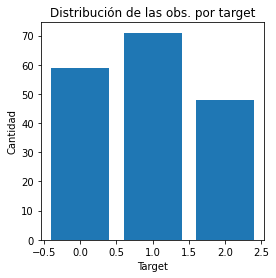

In [5]:
bar= dataset.groupby(['target'])['target'].count().reset_index(name="n")
bar= pd.DataFrame(bar)

fig = plt.figure(figsize =(4,4))
plt.bar(bar['target'],bar['n'])
plt.xlabel("Target")
plt.ylabel("Cantidad")
plt.title("Distribución de las obs. por target")
plt.show()


## Preprocesamiento

In [6]:
#Realizamos escalado y normalizacion de todos los predictores

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

#Selecciono solo los predictores

x = dataset.drop('target', axis=1)

np.random.seed(123)

#Escalado

escala=MinMaxScaler()

escala.fit(x)

x_escalada = escala.transform(x)

#print(x_escalada)

#Normalizado

normalize = Normalizer()

normalize.fit(x)

x_normalizada = normalize.transform(x)

#Estandarizado

estandarizado = StandardScaler()

estandarizado.fit(x)

x_estandarizada = estandarizado.transform(x)


#Corroboramos el estandarizado

print("------------------------------------")
print("Comprobaciones de la estandarizacion")
print("------------------------------------")
print(x_estandarizada.mean(axis=0)) #No es 0, pero es muy cercano a 0
print(x_estandarizada.std(axis=0)) #El desvio es 1 para todos los predictores.



------------------------------------
Comprobaciones de la estandarizacion
------------------------------------
[-8.38280756e-16 -1.19754394e-16 -8.37033314e-16 -3.99181312e-17
 -3.99181312e-17  0.00000000e+00 -3.99181312e-16  3.59263181e-16
 -1.19754394e-16  2.49488320e-17  1.99590656e-16  3.19345050e-16
 -1.59672525e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Division del dataset en train y test

In [7]:
# Comenzamos con los datos sin procesar
from sklearn.model_selection import train_test_split


X_train,X_test,y_train, y_test = train_test_split(
dataset.drop('target', axis=1),dataset['target'], random_state=123, test_size= 0.2)


In [8]:
#Continuamos con los datos preprocesados

from sklearn.model_selection import train_test_split

#Guardamos en el objeto y la variable target

y = dataset['target'].astype(int)

X_train_s,X_test_s,y_train_s, y_test_s = train_test_split(
x_estandarizada,y, random_state=123, test_size= 0.2)



## Entrenamos un modelo Knn

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

#Instanciamos el modelo

knn = KNeighborsClassifier(3)

#Entrenamos el modelo

original = knn.fit(X_train,y_train)
preprocesado = knn.fit(X_train_s,y_train_s)

#Hacemos predicciones

y_predicha_original = original.predict(X_test)

y_predicha_preprocesado = preprocesado.predict(X_test_s)

#Obtenemos algunas métricas de error

print("Accurracy")
print("--------------------------------------------")
print("El accuracy obtenido sin escalar es:", round(knn.score(X_test, y_test),3))
print("El accuracy obtenido preprocesado es:", round(knn.score(X_test_s, y_test_s),3))
print("--------------------------------------------")

#Obtenemos el roc_auc

print("ROC_AUC")
print("--------------------------------------------")
print("El roc_auc obtenido sin escalar es:", round(roc_auc_score(y_test,original.predict_proba(X_test),multi_class= 'ovo'),3))
print("El roc_auc obtenido preprocesado es:", round(roc_auc_score(y_test,preprocesado.predict_proba(X_test_s),multi_class= 'ovo'),3))
print("--------------------------------------------")


Accurracy
--------------------------------------------
El accuracy obtenido sin escalar es: 0.222
El accuracy obtenido preprocesado es: 0.972
--------------------------------------------
ROC_AUC
--------------------------------------------
El roc_auc obtenido sin escalar es: 0.5
El roc_auc obtenido preprocesado es: 0.999
--------------------------------------------
